# Simple Fits

- use the mean-field limit ODE for simple complete graph (fully connected case)

- synthetic tests:
  - use data from MF trajectory and fit MF to this
  
  - use data from Gillespie and fit MF

- play with least squares / grid search and abc potentially

For start:
- reproduce figure from Insights paper


In [1]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../src/')
from solve_kolmogorov import *
from simulate_gillespie import *
from Hypergraphs import *
from estimate_total_rates import *

from scipy.integrate import solve_ivp

## Setup

In [4]:
## -- Setup --
test_name = "simple_fits"

g_type = "complete"

N = 2500
g = CompleteHypergraph(N)

I0 = 500
nsims = 10

run_gillespie_simulations = False

time_max = 10

# 3 regimes
betas_unscaled_selected = [(3, 3), (3, 1.5), (1.5, 3)]
betas_unscaled = betas_unscaled_selected[0]
print(betas_unscaled)

beta1 = betas_unscaled[0] / N       # pairwise infection rate (tau = lambda / N)
beta2 = betas_unscaled[1] / (N**2)  # hyperedge contagion rate (beta = mu / N^2)
mu    = 1                           # recovery rate (gamma)

print(f"{test_name}: \n")
print(f"\t * H = Complete Hypergraph, N = {N}, I0 = {I0}, time_max = {time_max},")
print(f"\t * beta1 * N = {np.round(beta1 * N, 2)}")
print(f"\t * beta2 * N^2 = {np.round(beta2 * (N**2), 2)}")
print(f"\t * mu = {mu}")
print(f"\t * with estimation based on {nsims} Gillespie simulation runs\n")

(3, 3)
simple_fits: 

	 * H = Complete Hypergraph, N = 2500, I0 = 500, time_max = 10,
	 * beta1 * N = 3.0
	 * beta2 * N^2 = 3.0
	 * mu = 1
	 * with estimation based on 10 Gillespie simulation runs



## Run Gillespie

Normalize $X(t)$ curves `X_t[2] / N`, avg curve `avg_curve / N`, and $k^{*}$ `plt.axhline(y=int(0.75) ...`

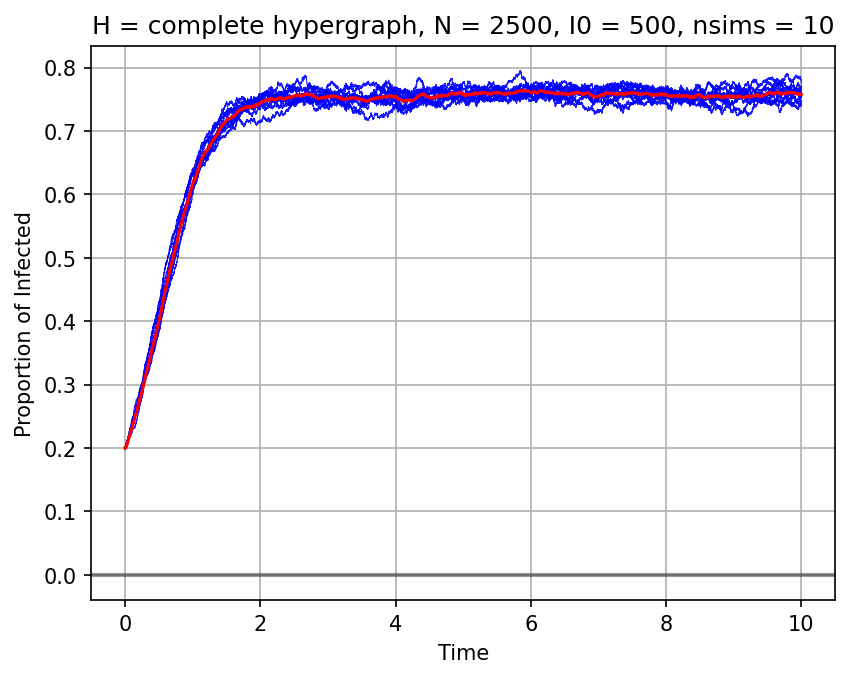

In [26]:
## --- Run Gillespie ---
# I0_gillespie = I0 # TODO: go over the range when necessary
# initial_infections = list(range(I0_gillespie))
if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        # X_t = gillespie_sim(g, beta1, beta2, mu, initial_infections, time_max)
        X_t = gillespie_sim_complete(N, beta1, beta2, mu, I0, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed(f'../results/gillespie-sims_{test_name}.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load(f'../results/gillespie-sims_{test_name}.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

# plot X_t curves in gray and average curve in red
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims:
    ax.plot(X_t[0], X_t[2] / N, c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

avg_curve, times = get_average(X_sims, time_max, nsims, delta_t = 0.01)
# avg_curve, times = get_average_corrected(X_sims, time_max, nsims, delta_t = 0.01)

plt.axhline(y=int(0.75), color='black', lw=2, alpha=0.4, linestyle='-')

plt.plot(times, avg_curve / N, "red")

plt.xlabel("Time")
plt.ylabel("Proportion of Infected")
plt.grid(True)
plt.title(f"H = complete hypergraph, N = {N}, I0 = {I0}, nsims = {nsims}")
plt.savefig(f"../figures/estimation/complete/{test_name}/gillespie-sims.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig) # free up memory

## Solve mean-filed limit ODE and compare

### Equation 2.18 from Insights paper

Let $y(t)$ be the proportion of infected nodes $k / N$ at time $t$, then in the limit

$$
\begin{equation}
dy/dt = (\lambda - \gamma) y + (\mu / 2 - \lambda) y^2 - (\mu / 2) y^3
\tag{2.18}
\end{equation}
$$

Translating to our notation:
\begin{align*}
\beta_1 &\leftarrow \lambda \\
\beta_2 &\leftarrow  \mu \\ 
\mu &\leftarrow \gamma
\end{align*}

Equation 2.18 becomes

$$
\begin{equation}
dy/dt = (\beta_1 - \mu) y + (\beta_2 / 2 - \beta_1) y^2 - (\beta_2 / 2) y^3
\tag{2.18*}
\end{equation}
$$

where parameters are scaled such that 
\begin{align*}
\beta_1 &\leftarrow \beta_1 N \\
\beta_2 &\leftarrow N^2
\end{align*}


In [12]:
# assuming complete hypergraph
def mean_field_ode(t, y, beta1_scaled, beta2_scaled, mu_recovery):
    r"""Mean-field ODE dy/dt for SIS model on complete hypergraph: 
    Equation 2.18 from Insights from exact social contagion dynamics on 
    networks with higher-order structures, Kiss et al. 2023.
    """
    dydt = (beta1_scaled - mu_recovery) * y \
        + (beta2_scaled / 2.0 - beta1_scaled) * y**2 \
        - (beta2_scaled / 2.0) * y**3
    return dydt

In [ ]:
def solve_mean_field(N, I0, beta1_true, beta2_true, mu_recovery, time_max, num_steps=101):
    beta1_scaled = beta1_true * N
    beta2_scaled = beta2_true * (N**2)
    
    # initial condition is proportion of infected
    y0 = I0 / N

    # time span and evaluation points
    t_span = (0.0, time_max)
    t_eval = np.linspace(t_span[0], t_span[1], num_steps)

    # solve the ODE using LSODA
    sol = solve_ivp(
        mean_field_ode,
        t_span,
        [y0],
        method='LSODA',
        t_eval=t_eval,
        args=(beta1_scaled, beta2_scaled, mu_recovery)
    )
    return sol

In [24]:
print(f"Unscaled (beta1, beta2, mu) =  {tuple(np.round([beta1 * N, beta2 * (N**2), mu], 2))}")

Unscaled (beta1, beta2, mu) =  (np.float64(3.0), np.float64(3.0), np.float64(1.0))


In [25]:
mf_sol = solve_mean_field(N, I0, beta1, beta2, mu, time_max)

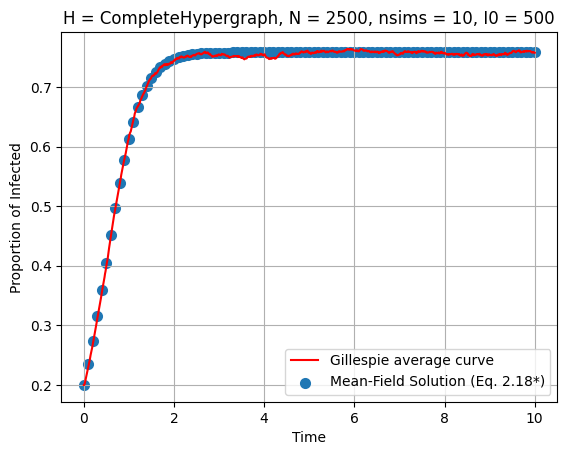

In [34]:
# plot both the MF solution and Gillespie average curve / N

plt.figure()
plt.plot(times, avg_curve / N, 'red', label="Gillespie average curve")

plt.scatter(mf_sol.t, mf_sol.y[0], lw=2, marker='o', label='Mean-Field Solution (Eq. 2.18*)')

# plt.axhline(y=int(0.75), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Proportion of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}, I0 = {I0}")
plt.savefig(f"../figures/estimation/complete/{test_name}/mf-solution-vs-gillespie.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()